In [1]:
import astropy.units as u
import astropy.constants as c
import numpy as np 
import matplotlib.pyplot as plt
import sys 
sys.path.append('/Users/clairewilliams/opt/anaconda3/lib/python3.9/site-packages')
sys.path.append('../model-timescales/src')
import pandas

from timescales.data import build_bulk_energy_grid
from timescales import TimescaleEnsemble
from timescales.analysis.tables import structural_table, timescale_table
from timescales.analysis.tools import get_system
from timescales.analysis.recipes import generate_timescale_comparison,collision_vs_main_sequence, destructive_colllision_criterion
from timescales import physics as phys


In [2]:
masses_array   = np.logspace(4, 8, 20) * u.Msun
radii_array    = np.logspace(-0.7, 2, 20) * u.pc
velocity_array = np.logspace(-0.7, 2.2, 20) * u.km/u.s

grid = build_bulk_energy_grid(masses_array, radii_array, velocity_array,
                              alpha=3/5, energy_unit=u.erg)


# Example: access aligned arrays
M = grid['M']   # Msun
R = grid['R']   # pc
V = grid['V']   # km/s
K = grid['K']   # erg
U = grid['U']   # erg

print(len(M), len(R), len(V), len(K), len(U))  # -> 1_000_000 each (100*100*100

1404 1404 1404 1404 1404


In [3]:
pl_175_1Msun = TimescaleEnsemble(grid, densityModel="power-law", profile_kwargs={"alpha":1.75})

Using power-law model with properties:
alpha=1.75
No timescale arguments given. Defaulting to eccentricity 0, Mstar 1Msun.


In [4]:
tab_pl_175_1Msun = generate_timescale_comparison(pl_175_1Msun, as_ = 'pandas')


will use defaults for  {'Mcollisions': <Quantity 1. solMass>, 'n_unit': <Quantity 1. 1 / cm3>, 'v_unit': Unit("cm / s"), 'Mstar_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}


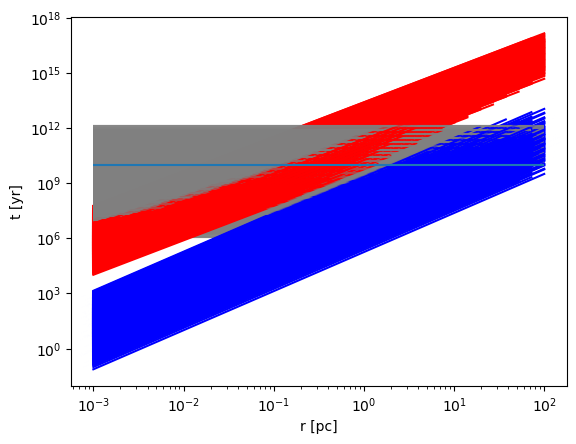

In [6]:
table = tab_pl_175_1Msun
N  = len(set(table['system_id']))
ids = pandas.unique(table["system_id"])
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_xscale("log")
for sys_id in ids:
    sys_data = get_system(table,sys_id, as_df= True)
    if sys_data.empty:
        continue
    x=u.Quantity(sys_data['r'].to_list()).to_value(u.pc)
    y = u.Quantity(sys_data['t_coll'].to_list()).to_value(u.yr)
    ax.plot(x,y, color = "red")

    y = u.Quantity(sys_data['t_relax'].to_list()).to_value(u.yr)
    ax.plot(x,y, color = "blue")

    clustermass = pl_175_1Msun.grid['M'][sys_id]
    clusterradius = pl_175_1Msun.grid['R'][sys_id]
    M_BH = 10*u.Msun
    df_timescale = phys.dynamical_friction.dynamical_friction_timescale(clustermass, M_BH, clusterradius)
    ax.hlines(df_timescale.to_value('yr'), xmin = min(x), xmax =max(x), color = "grey",alpha =0.5)

ms_timescale = phys.stars.main_sequence_lifetime_approximation(1*u.Msun).to_value('yr')

ax.hlines(ms_timescale, xmin = min(x), xmax =max(x))
ax.set_xlabel("r [pc]")
ax.set_ylabel("t [yr]")
plt.show()
